# Surface transmission-Loss inversion using local infrasound data
This notebook can be used to retrieve infrasound Transmission Loss (TL) values near the 2020 Kiruna minequake epicenter using backazimuth and amplitude data recorded at KRIS. 

The methodology is further described in Turquet, Brissaud et al, "Retrieving seismic source characteristics using seismic and infrasound data: The 2020 mb 4.9 Kiruna minequake, Sweden", Geophysical Research Letters, 2024

Code developed by Quentin Brissaud

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyproj import Geod
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline  

In [2]:
def proba_normal(x, mean, std):
    return np.exp(-((x-mean)**2)/(2*std**2))
#(1/np.sqrt(2*np.pi*(std**2)))*

def get_params(ev_loc, station_loc, vmean, vstd, nb_v, v_distrib, bazstd, nb_baz, baz_distrib):
    
    wgs84_geod = Geod(ellps='WGS84')
    _, az21, dist_orig = wgs84_geod.inv(ev_loc[1], ev_loc[0], station_loc[1], station_loc[0])
    az21 = az21 if az21 > 0 else az21 + 360
    
    if v_distrib == 'normal':
        vels = np.random.normal(vmean, vstd, nb_v)
        vels_proba = proba_normal(vels, vmean, vstd)
    elif v_distrib == 'uniform':
        vels = np.random.uniform(vmean, vstd, nb_v)
        vels_proba = vels*0 + 1
    else:
        print('Problem vel distribution')
        
    if baz_distrib == 'normal':
        errbazs = np.random.normal(0., bazstd, nb_baz)
        errbazs_proba = proba_normal(errbazs, 0, bazstd)
    elif baz_distrib == 'uniform':
        errbazs = np.random.uniform(0., bazstd, nb_baz)
        errbazs_proba = errbazs*0 + 1
    else:
        print('Problem baz distribution')

    if org_distrib == 'normal':
        errorg = np.random.normal(0., orgstd, nb_org)
        errorg_proba = proba_normal(errorg, 0, orgstd)
    elif org_distrib == 'uniform':
        errorg = np.random.uniform(-orgstd, orgstd, nb_org)
        errorg_proba = errorg*0 + 1
    else:
        print('Problem baz distribution')

    return az21, vels, vels_proba, errbazs, errbazs_proba, errorg, errorg_proba, dist_orig
    
ev_loc = (67.84169, 20.207277)
ev_loc = (67.83965, 20.20759) #celso
#ev_time = np.datetime64('2020-05-18T01:11:51.88')
ev_time = np.datetime64('2020-05-18T01:11:57')
ev_time = np.datetime64('2020-05-18T01:11:56.2') #from celso
station_loc = (67.8549, 20.4220)
vmean, vstd, nb_v, v_distrib = 0.33, 0.008, 15, 'normal'
bazstd, nb_baz, baz_distrib = 5., 10, 'uniform'
orgstd, nb_org, org_distrib = 0.2, 10, 'uniform'
max_dev_baz = 5
focal_depth = 1
vels_seismic = 3

az21, vels, vels_proba, errbazs, errbazs_proba, errorg, errorg_proba, dist_orig = get_params(ev_loc, station_loc, vmean, vstd, nb_v, v_distrib, bazstd, nb_baz, baz_distrib)

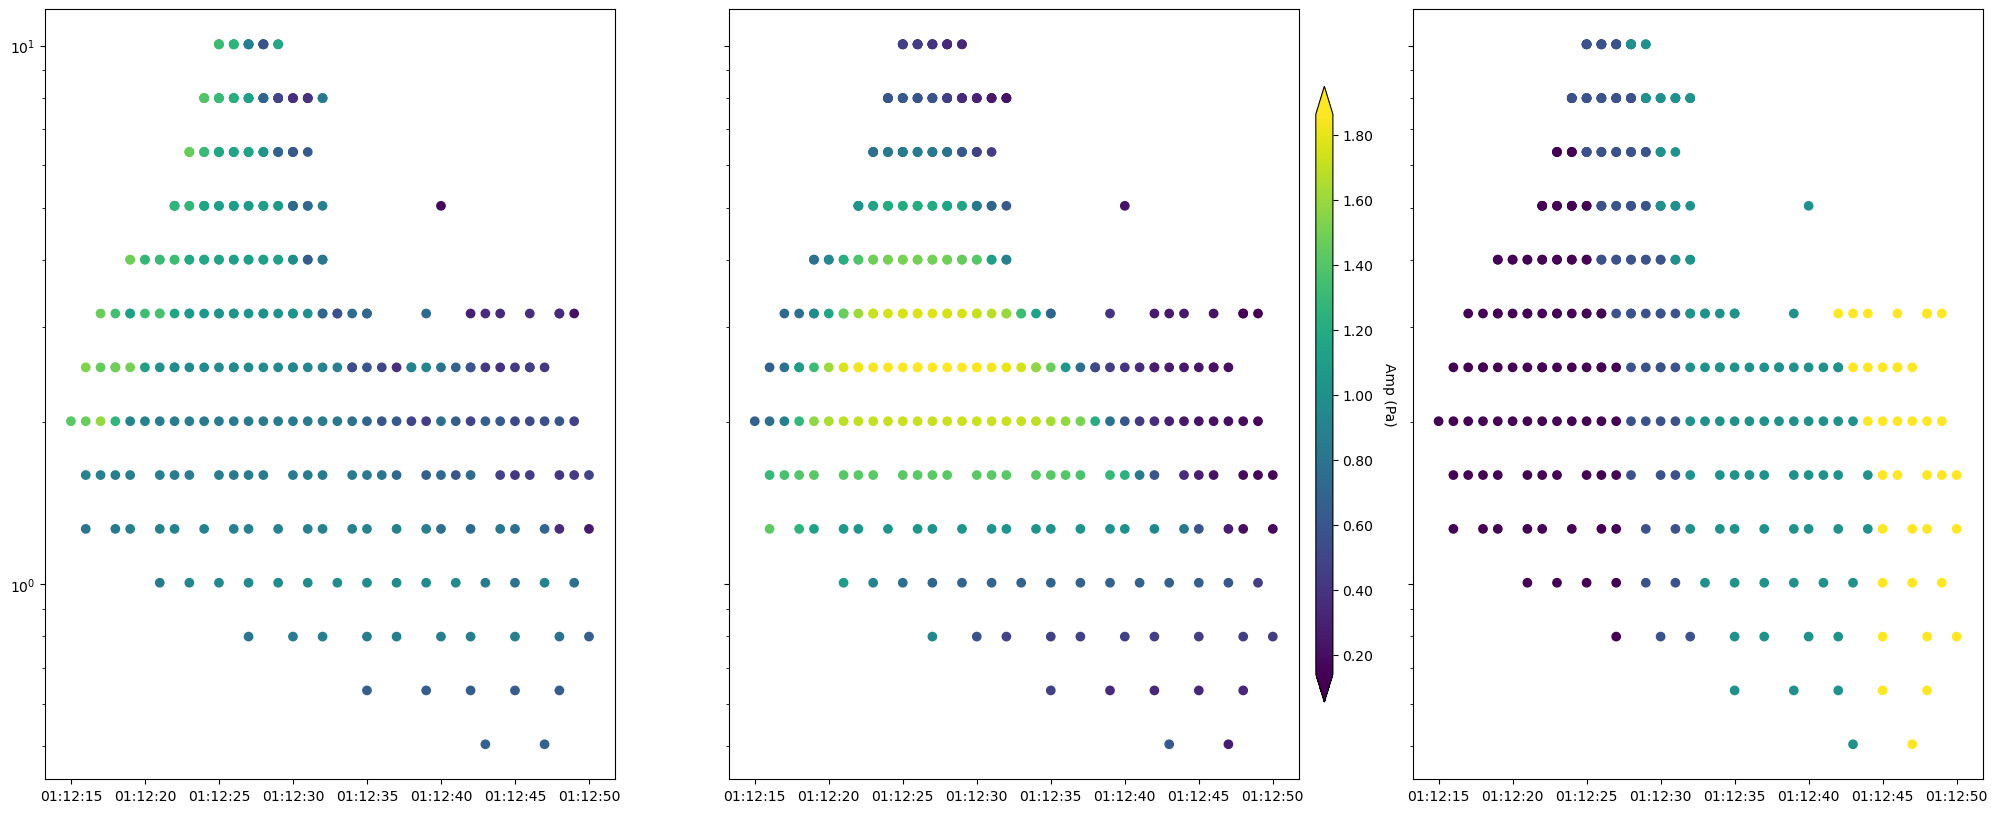

In [3]:
def add_cbar(ax, sc, label='SPL (db)', format_cbar='%d'):
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = plt.colorbar(sc, cax=axins, extend='both', format=format_cbar)
    cbar.ax.set_ylabel(label, rotation=270, labelpad=16)

def load_Alexis(file, min_az=250, max_az=280, min_freq=0.1, max_freq=10, min_time=np.datetime64('2020-05-18T01:12:15'), max_time=np.datetime64('2020-05-18T01:12:50')):
    sensitivity = 8.3261e-08
    #data = pd.read_csv(file, header=[0])
    data = pd.read_csv(file)
    data.columns = ['DetectionID', 'Azimuth','Amplitude','Time','Frequency','Speed']
    data.Amplitude *= sensitivity
    data.Time = pd.to_datetime(data.Time/3600/24, unit='d').round('s');
    
    data = data.loc[data.DetectionID!=-1]
    data = data.loc[(data.Azimuth>min_az) & (data.Azimuth<max_az)]
    data = data.loc[(data.Time>=min_time) & (data.Time<=max_time)]
    data.columns = ['DetectionID', 'az', 'amp', 't', 'f', 'vel']
    data = data.loc[(data.f>=min_freq) & (data.f<=max_freq)]
    
    return data

file = './AlexisKIR_v2.csv'
data_toplot_all = load_Alexis(file, min_az=200, max_az=360, min_freq=0.001, max_freq=30, min_time=np.datetime64('2020-05-18T01:12:15'), max_time=np.datetime64('2020-05-18T01:12:50'))
data_toplot = data_toplot_all.loc[abs(data_toplot_all.az - az21) < max_dev_baz]

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(25,10))
sc = axs[0].scatter(data_toplot.t, data_toplot.f, c=data_toplot.az, vmax=az21+max_dev_baz, vmin=az21-max_dev_baz); 
axs[0].set_yscale('log'); 

sc = axs[1].scatter(data_toplot.t, data_toplot.f, c=data_toplot.amp); 
axs[1].set_yscale('log'); 
add_cbar(axs[1], sc, label='Amp (Pa)', format_cbar='%.2f')

sc = axs[2].scatter(data_toplot.t, data_toplot.f, c=data_toplot.DetectionID); 
axs[2].set_yscale('log'); 

#loads the file from Alexis about PMCC results and plots time frequency and velocity/ amplitude /detection ID 

In [4]:
def distance_correction_seismic(focal_depth, v_a, v_s):
    return np.sqrt(-focal_depth/(1-(v_s/v_a)**2))

def invert_locations(data_toplot_all, az21, max_dev_baz, errbazs, errbazs_proba, vels, vels_proba, station_loc, dist_orig, focal_depth, vels_seismic, scaling_TL=10):
    
    focal_depth = 1e3
    
    data_toplot = data_toplot_all.loc[abs(data_toplot_all.az - az21) < max_dev_baz]
    BAZS, ERRBAZS, VELS, ERRORG = np.meshgrid(data_toplot.az.values, errbazs, vels, errorg)
    IDS, _, _, _= np.meshgrid(np.arange(data_toplot.az.values.size), errbazs, vels, errorg)
    _, ERRBAZS_PROBA, VELS_PROBA, ORG_PROBA = np.meshgrid(data_toplot.az.values, errbazs_proba, vels_proba, errorg_proba)
    AMPLITUDES, _, _, _ = np.meshgrid(data_toplot.amp.values, errbazs, vels, errorg)
    TIMES, _, _, _ = np.meshgrid((data_toplot.t-ev_time).dt.total_seconds().values, errbazs, vels, errorg)
    
    BAZS, ERRBAZS, VELS, AMPLITUDES, ERRBAZS_PROBA, VELS_PROBA, IDS, ERRORG, ORG_PROBA = BAZS.ravel(), ERRBAZS.ravel(), VELS.ravel(), AMPLITUDES.ravel(), ERRBAZS_PROBA.ravel(), VELS_PROBA.ravel(), IDS.ravel(), ERRORG.ravel(), ORG_PROBA.ravel()
    TIMES = TIMES.ravel() + ERRORG
    BAZS += ERRBAZS
    DISTANCES = VELS * (TIMES)
    DISTANCES -= distance_correction_seismic(focal_depth, VELS, vels_seismic)
    std_dist = 2.
    ERRDIST_PROBA = np.exp(-((DISTANCES-dist_orig/1e3)/std_dist)**2)
    #print(DISTANCES, dist_orig, ERRDIST_PROBA)
    
    LONS = np.repeat(station_loc[1], DISTANCES.size)
    LATS = np.repeat(station_loc[0], DISTANCES.size)
    wgs84_geod = Geod(ellps='WGS84')
    endlon, endlat, _ = wgs84_geod.fwd(LONS, LATS, BAZS, DISTANCES*1e3)
    amp_corrected = AMPLITUDES * DISTANCES * 1e3
    #TL = 20*np.log(amp_corrected/np.max(amp_corrected))
    TL = 20*np.log(amp_corrected/scaling_TL)
    
    
    
    return endlon, endlat, ERRBAZS, VELS, ERRBAZS_PROBA, VELS_PROBA, amp_corrected, TL, IDS, ERRORG, ORG_PROBA, ERRDIST_PROBA

#offset_data_ev = (pd.to_datetime(ev_time) - pd.to_datetime(data_time)).total_seconds()
endlon, endlat, ERRBAZS, VELS, ERRBAZS_PROBA, VELS_PROBA, amp_corrected, TL, IDS, ERRORG, ORG_PROBA, ERRDIST_PROBA = invert_locations(data_toplot_all, az21, max_dev_baz, errbazs, errbazs_proba, vels, vels_proba, station_loc, dist_orig, focal_depth, vels_seismic)

In [5]:
def add_cbar(ax, sc, label='SPL (db)', format_cbar='%d'):
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = plt.colorbar(sc, cax=axins, extend='both', format=format_cbar)
    cbar.ax.set_ylabel(label, rotation=270, labelpad=16)

def project_on_grid(endlon, endlat, ERRBAZS, VELS, ERRBAZS_PROBA, VELS_PROBA, ORG_PROBA, ERRDIST_PROBA, amp_corrected, TL, IDS, ev_loc, nb_lon=25, nb_lat=11, lim_proba=0.7):
    
    lons, lats = np.linspace(endlon.min(), endlon.max(), nb_lon), np.linspace(endlat.min(), endlat.max(), nb_lat)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    lon_grid, lat_grid = lon_grid.ravel(), lat_grid.ravel()
    LONS, ENDLONS = np.meshgrid(lon_grid, endlon)
    LATS, ENDLATS = np.meshgrid(lat_grid, endlat)
    _, LAT_PROBAS = np.meshgrid(lat_grid, 1*VELS_PROBA*ERRDIST_PROBA*ERRBAZS_PROBA*ORG_PROBA)
    _, LON_PROBAS = np.meshgrid(lon_grid, 1*VELS_PROBA*ERRDIST_PROBA*ERRBAZS_PROBA*ORG_PROBA)
    _, LON_TL = np.meshgrid(lon_grid, TL)
    _, LON_IDS = np.meshgrid(lon_grid, IDS)
    DIST_LON = abs(LONS-ENDLONS)
    DIST_LAT = abs(LATS-ENDLATS)
    lim_lon = (lons[1]-lons[0])/2.
    lim_lat = (lats[1]-lats[0])/2.
    LON_PROBAS[DIST_LON>lim_lon] = 0
    LAT_PROBAS[DIST_LAT>lim_lat] = 0
    #LON_PROBAS[(DIST_LON>lim_lon)&(DIST_LAT>lim_lat)] = 0
    LON_PROBAS *= LAT_PROBAS #not sure about this line
    LON_PROBAS = np.sqrt(LON_PROBAS)
    LON_PROBAS[LON_PROBAS<lim_proba] = 0
    LON_TL[LON_PROBAS==0] = -1e10
    
    print(LON_PROBAS.shape)
    if True:
        pd_inds = pd.DataFrame()
        pd_inds['ii'] = np.arange(LON_PROBAS.shape[0]*LON_PROBAS.shape[1])[LON_PROBAS.ravel()>=lim_proba]
        pd_inds['ID'] = LON_IDS[LON_PROBAS>=lim_proba].ravel()
        pd_inds['LON'] = LONS[LON_PROBAS>=lim_proba].ravel()
        pd_inds['LAT'] = LATS[LON_PROBAS>=lim_proba].ravel()
        pd_inds['TL'] = LON_TL[LON_PROBAS>=lim_proba].ravel()
        pd_inds['ind'] = pd_inds.groupby(['ID', 'LON', 'LAT'])['TL'].transform('idxmax')
        
        #return pd_inds
    
    INDS = np.argmax(LON_TL, axis=0)
    TL_grid = TL[INDS]
    PROBA_grid = VELS_PROBA*ERRBAZS_PROBA
    PROBA_grid = PROBA_grid[INDS]
    
    if True:
        data=pd.DataFrame()
        data['lon'] = lon_grid
        data['lat'] = lat_grid
        data['TL'] = TL_grid
        data.to_csv('data_Kiruna.csv', header=True, index=False)
    
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    sc = axs[0].scatter(lon_grid, lat_grid, c=TL_grid, marker='s', s=50)
    add_cbar(axs[0], sc, label='TL (db)')
    sc = axs[1].scatter(lon_grid, lat_grid, c=PROBA_grid, marker='s', s=50)
    add_cbar(axs[1], sc, label='Proba', format_cbar='%.2f')
    axs[1].set_xlim([19.9, 20.3])
    axs[1].set_ylim([67.8, 67.85])
    
    for ax in axs:
        ax.scatter(ev_loc[1], ev_loc[0], marker='*', color='red')
    
    return pd_inds
    #print(LON_PROBAS.shape, INDS.shape, TL[INDS].shape)
pd_inds = project_on_grid(endlon, endlat, ERRBAZS, VELS, ERRBAZS_PROBA, VELS_PROBA,ORG_PROBA, ERRDIST_PROBA, amp_corrected, TL, IDS, ev_loc, nb_lon=25, nb_lat=25, lim_proba=0.5)

C:\Users\antoine\AppData\Local\Temp\ipykernel_38352\53283293.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc = axs.pcolormesh(LONS, LATS, TLS, zorder=10, cmap=my_cmap, vmax=160,vmin=100 )


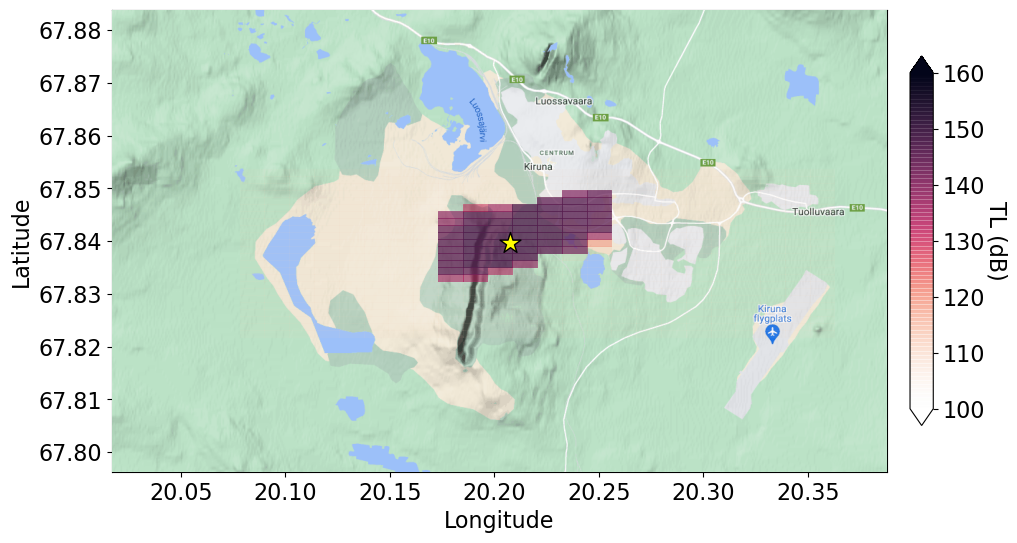

In [ ]:
import scipy.ndimage as ndimage
import scipy.io
plt.rcParams.update({'font.size': 16})
def add_img_map(axs, dir_image_map, upperleft, lowerright, zorder=5):

    #from importlib import reload; reload(utils_figures)
    img_kiruna = plt.imread(dir_image_map)
    h, w = img_kiruna.shape[:2]
    aspect = w/h
    base = 15
    
    axs.imshow(img_kiruna, extent=[upperleft[1], lowerright[1], lowerright[0], upperleft[0]], aspect='auto', zorder=zorder)
    
    return axs

def plot_map(dir_image_map, upperleft, lowerright, ev_loc, data, type_map='alexis'):
    
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize = (10, 6))
    axs = add_img_map(axs, dir_image_map, upperleft, lowerright, zorder=5)
        
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)
    
    if type_map == 'quentin':
        nb_lon, nb_lat = data.lon.unique().size, data.lat.unique().size
        LONS = data.lon.values.reshape(nb_lat, nb_lon)
        LATS = data.lat.values.reshape(nb_lat, nb_lon)
        TLS = data.TL.values.reshape(nb_lat, nb_lon)
        sc = axs.pcolormesh(LONS, LATS, TLS, zorder=10, cmap=my_cmap, vmax=160,vmin=100 )
        
    else:
        SPL_imag = np.zeros(data['SPL'].shape)
        SPL_imag[np.where(data['SPL'] > 0)] = data['SPL'][np.where(data['SPL'] > 0)]
        SPL_imag = ndimage.gaussian_filter(SPL_imag, sigma=2, order=0)
        sc = axs.pcolormesh(data['LON_LOC'][0,:], data['LAT_LOC'][0,:], data['SPL'], alpha=0.25, cmap='inferno', zorder=10, shading='auto')
        cs = axs.contour(data['LON_LOC'][0,:], data['LAT_LOC'][0,:], SPL_imag, levels=[110, 115, 120], zorder=12, colors='black')
    
    add_cbar(axs, sc, label='TL (dB)')
    axs.scatter(ev_loc[1], ev_loc[0], marker='*', color='yellow', zorder=15, s=250, edgecolor='black')
    axs.set_xlim([upperleft[1], lowerright[1]])
    axs.set_ylim([lowerright[0], upperleft[0]])
    
    return fig, axs
    
dir_image_map = './best_map_Kiruna.png'
upperleft =  67.88386422255157, 20.017005795485694
lowerright = 67.79628369301288, 20.387876552454884
ev_loc = (67.84169, 20.207277)
ev_loc = (67.83965, 20.20759) #celso
type_map = 'quentin'
#type_map = 'alexis'
if type_map == 'quentin':
    data = pd.read_csv('./data_Kiruna.csv')
else:
    dir_lepichon_SPL = './SPL_KIR.mat'
    data = scipy.io.loadmat(dir_lepichon_SPL)

wgs84_geod = Geod(ellps='WGS84')
fig, axs = plot_map(dir_image_map, upperleft, lowerright, ev_loc, data, type_map=type_map)
data_toplot = data_toplot_all.loc[abs(data_toplot_all.az - az21) < max_dev_baz]
pt_min_dev = wgs84_geod.fwd(station_loc[1], station_loc[0], data_toplot.az.min()-bazstd, 1e5)
pt_max_dev = wgs84_geod.fwd(station_loc[1], station_loc[0], data_toplot.az.max()+bazstd, 1e5)
#axs.plot([station_loc[1], pt_min_dev[0]], [station_loc[0], pt_min_dev[1]], color='black', linestyle=':', zorder=100)
#axs.plot([station_loc[1], pt_max_dev[0]], [station_loc[0], pt_max_dev[1]], color='black', linestyle=':', zorder=100)
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
fname = str(ev_time)
fname = fname[0:10] + '_' + fname[11:13] + '_' + fname[14:16] +'_' + fname[17:19] + 'noline.png'
fig.savefig(fname)
fname = fname[0:10] + '_' + fname[11:13] + '_' + fname[14:16] +'_' + fname[17:19] + 'noline.pdf'
fig.savefig(fname,bbox_inches='tight')

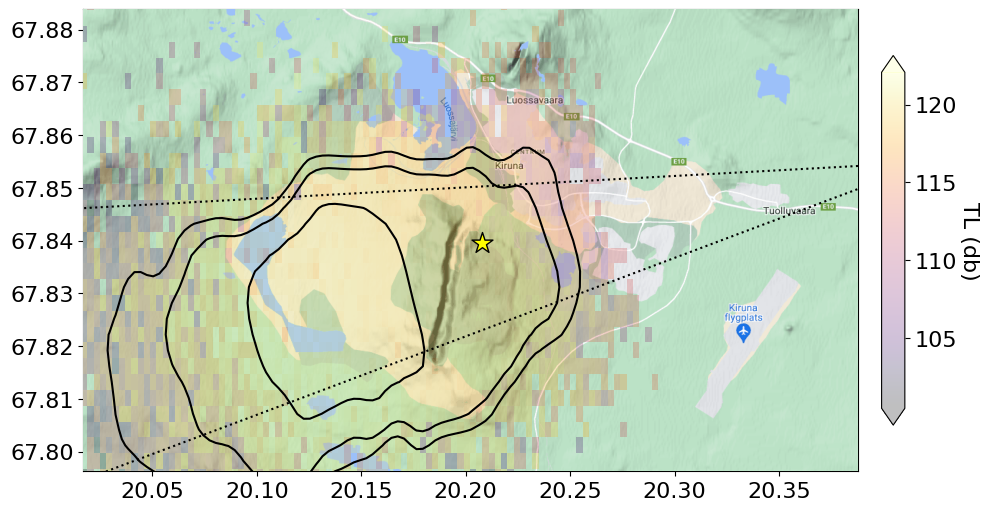

In [9]:

type_map = 'alexis'
if type_map == 'quentin':
    data = pd.read_csv('./data_Kiruna.csv')
else:
    dir_lepichon_SPL = './SPL_KIR.mat'
    data = scipy.io.loadmat(dir_lepichon_SPL)

fig, axs = plot_map(dir_image_map, upperleft, lowerright, ev_loc, data, type_map=type_map)
data_toplot = data_toplot_all.loc[abs(data_toplot_all.az - az21) < max_dev_baz]
pt_min_dev = wgs84_geod.fwd(station_loc[1], station_loc[0], data_toplot.az.min()-bazstd, 1e5)
pt_max_dev = wgs84_geod.fwd(station_loc[1], station_loc[0], data_toplot.az.max()+bazstd, 1e5)
axs.plot([station_loc[1], pt_min_dev[0]], [station_loc[0], pt_min_dev[1]], color='black', linestyle=':', zorder=100)
axs.plot([station_loc[1], pt_max_dev[0]], [station_loc[0], pt_max_dev[1]], color='black', linestyle=':', zorder=100)
#fig.savefig('test.pdf', dpi=550)